In [1]:
import pandas as pd

## A. Data Preparation

In [2]:
data = pd.read_csv('spooky.csv')
data.head(10)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
5,id22965,"A youth passed in solitude, my best years spen...",MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,I knew that you could not say to yourself 'ste...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


## B. Text Cleaning

### 1. Handle repetitive characters (e.g., "cooooool" → "cool").

In [6]:
import re
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
repl = r'\1\2\3'

def replace(word):
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)

    if repl_word != word:
        return replace(repl_word)
    else:
        return repl_word
    
def remove_repeating_chars(text):
    words = text.split()
    new_words = []
    for word in words:
        new_words.append(replace(word))
    return ' '.join(new_words)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\friha\AppData\Roaming\nltk_data...


In [7]:
remove_repeating_chars('coool and Coooooool niice broo!')

'cool and Cool nice bro!'

### 2. Manage homoglyphs (e.g., "$tupide" → "stupide")

In [8]:
import unicodedata

def remove_accented_chars_func(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [15]:
remove_accented_chars_func('dépasser')

'depasser'

### 3. Transform special entries such as URLs, email addresses, and HTML tags into a canonical form.

In [16]:
import re 

def remove_url_func(text):
    return re.sub(r'https?://\S+|www\.\S+', '[URL]', text)

In [12]:
remove_url_func('https://github.com  https://youtube.com/search?q=')

'[URL]  [URL]'

In [19]:
from bs4 import BeautifulSoup

def remove_html_tags_func(text):
    return BeautifulSoup(text, 'html.parser').get_text()

In [18]:
remove_html_tags_func('<html><body><h3>This is heading 3</h3></body></html>')

'This is heading 3'

In [20]:
import re
def remove_email_func(text):
    return re.sub(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)','[EMAIL]', text)

In [21]:
remove_email_func('yupi a.frihaoui@esi-sba.dz  sdf example@domain.com fdsf')

'yupi [EMAIL]  sdf [EMAIL] fdsf'

### 4. Convert all characters to lowercase.

In [22]:
def to_lower(text):
    return text.lower()

In [23]:
to_lower('Hello World!')

'hello world!'

### 5. Remove punctuation.

In [24]:
import string

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [25]:
remove_punctuation('Hello, I hope this email finds you well.')

'Hello I hope this email finds you well'

### 6. Remove stop words.

In [26]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [29]:
remove_stopwords( "Here is an example sentence containing stopwords.")

'example sentence containing stopwords .'

# C. Tokenization

### 1. Tokenize each sentence based on spaces / punctuation.

In [30]:
from nltk.tokenize import word_tokenize
import string

def tokenize_sentence(sentence):
    # Define the set of punctuation marks to exclude
    exclude = set(string.punctuation)
    
    # Tokenize the sentence
    tokens = word_tokenize(sentence)
    
    # Filter out punctuation marks
    tokens = [token for token in tokens if not all(char in exclude for char in token)]
    
    return tokens

In [31]:
tokenize_sentence("This is a sample, sentence with. punctuation marks!")

['This', 'is', 'a', 'sample', 'sentence', 'with', 'punctuation', 'marks']

### 2. Tokenize each sentence using a rule-based tokenization algorithm.

In [34]:
import re

def rulebase_tokenize(text):
    # separate out clitics
    text = re.sub(r"([’'`])\s", "", text)
    text = re.sub(r"\s(n't|N'T|'(s|S|m|M|ll|LL|d|D|ve|VE))\b", "", text)

    # keep hyphenated words together
    text = re.sub(r"(\S+)-\s*(\S+)", "", text)

    # separate out all punctuation except periods and commas
    text = re.sub(r"([^\w\s\.,])", "", text)

    # separate out commas if they're not part of a number
    text = re.sub(r"(?<!\d),(?!\d)", r" , ", text)

    # split text into tokens and remove extra spaces
    tokens = re.split(r"\s+", text.strip())
    return tokens

In [35]:
rulebase_tokenize("It's a beautiful day, isn't it? I can't wait to go outside and enjoy it!")

['Its',
 'a',
 'beautiful',
 'day',
 ',',
 'isnt',
 'it',
 'I',
 'cant',
 'wait',
 'to',
 'go',
 'outside',
 'and',
 'enjoy',
 'it']

### 3. Tokenize each sentence using a subword tokenization algorithm.

In [37]:
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers

def tokenize_sentence_with_bpe(sentence):
    # Define the BPE model
    bpe_model = models.BPE()

    # Define the trainer with the BPE algorithm and fit it on the sentence
    trainer = trainers.BpeTrainer(special_tokens=["<s>", "<pad>", "</s>", "<unk>", "<mask>"])
    tokenizer = Tokenizer(bpe_model)
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer.decoder = decoders.BPEDecoder()
    tokenizer.train_from_iterator([sentence], trainer=trainer)

    # Segment the sentence into subwords using the BPE tokenizer
    subwords = tokenizer.encode(sentence).tokens

    return subwords

In [38]:
tokenize_sentence_with_bpe("This is a sample sentence to be segmented into subwords.")

['This',
 'is',
 'a',
 'sample',
 'sentence',
 'to',
 'be',
 'segmented',
 'into',
 'subwords',
 '.']

# D. Named Entity Recognition

In [45]:
import spacy

def extract_named_entities(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]

    named_entities = []
    for sentence in sentences:
        sentence_doc = nlp(sentence)
        for entity in sentence_doc.ents:
            named_entities.append(entity.text)

    return named_entities

In [46]:
text = "Barack Obama was the 44th President of the United States. He served from 2009 to 2017."
extract_named_entities(text)

['Barack Obama', '44th', 'the United States', '2009 to 2017']

# E. Form Reduction

In [53]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('averaged_perceptron_tagger')

def reduce_text(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    
    # Lemmatize each word using WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    
    # Stem each word using PorterStemmer
    stemmer = PorterStemmer()
    stems = [stemmer.stem(word) for word in words]
    
    return lemmas, stems

# Helper function to map part-of-speech tags to WordNet part-of-speech codes
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\friha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [54]:
text = "The quick brown foxes jumped over the lazy dogs."
lemmas, stems = reduce_text(text)
print('lemmas :',lemmas)
print('stems :',stems)

lemmas : ['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', '.']
stems : ['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog', '.']


# F. Frequency Analysis

### 1. Count the number of sentences, for each author, where the word `"Great"` appears.

In [57]:
import re
import pandas as pd

# define a function to count the number of sentences containing the word "Great"
def count_word_sentences(text,word):
    sentences = re.findall(r'\b.*?[.!?]', text)
    return sum(word in sentence for sentence in sentences)

# apply the count_great_sentences function to the 'text' column and create a new column for the results
data['word_sentence_count'] = data['text'].apply(lambda x:count_word_sentences(x,'Great'))

# group the dataframe by author and sum the 'great_sentence_count' column for each author
great_counts = data.groupby('author')['word_sentence_count'].sum()

print(great_counts)

author
EAP     6
HPL    22
MWS     7
Name: word_sentence_count, dtype: int64


### 2. Use `pywaffle` to obtain a graph summarizing the number of occurrences of the word `"great"` per author.

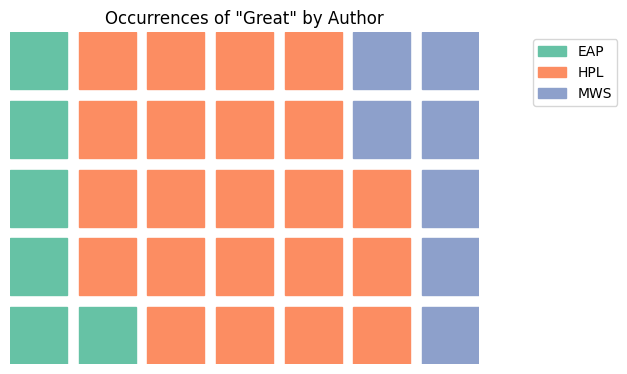

In [58]:
from pywaffle import Waffle
import matplotlib.pyplot as plt


# create a waffle chart to visualize the great_counts by author
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=list(great_counts),
    labels=list(great_counts.index),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)

plt.title('Occurrences of "Great" by Author')
plt.show()

### 3. Repeat the analysis with the word `"impossible"`.

In [59]:
data['word_sentence_count'] = data['text'].apply(lambda x:count_word_sentences(x,'impossible'))

impossible_counts = data.groupby('author')['word_sentence_count'].sum()

print(impossible_counts)

author
EAP    60
HPL    16
MWS    19
Name: word_sentence_count, dtype: int64


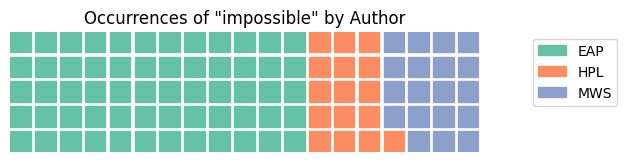

In [60]:
from pywaffle import Waffle
import matplotlib.pyplot as plt

fig = plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=list(impossible_counts),
    labels=list(impossible_counts.index),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)

plt.title('Occurrences of "impossible" by Author')
plt.show()

### 4. Using the `wordCloud` function, create three word clouds to represent the most used words by each author.

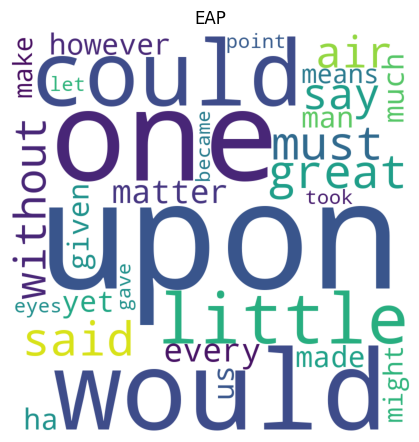

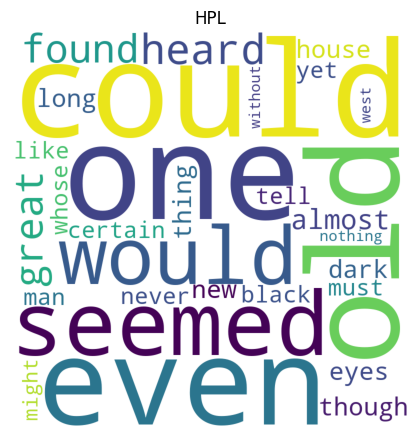

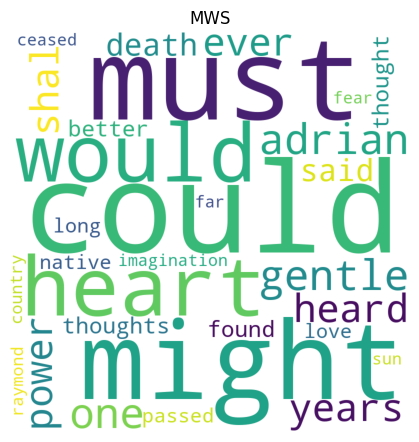

In [61]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import nltk


# load the dataset
df = data

# load the English tokenizer, tagger, and stop words list
nlp = spacy.load('en_core_web_sm')

# group the text by author
grouped = df.groupby('author')

# loop over the groups
for author, group in grouped:
    # concatenate all the text into a single string
    text = ' '.join(group['text'])[0:20000]
    
    # tokenize the text using spaCy
    text = remove_repeating_chars(text)
    text = remove_accented_chars_func(text)
    text = remove_url_func(text)
    text = remove_html_tags_func(text)
    text = remove_email_func(text)
    text = to_lower(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    
    tokens = tokenize_sentence(text)
    
    # count the frequency of each word
    word_counts = Counter(tokens)
    most_common_words = word_counts.most_common(30)
    
    # generate the word cloud
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          stopwords = stopwords, 
                          min_font_size = 10).generate_from_frequencies(dict(most_common_words))
    
    # plot the WordCloud image                      
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(author)
    
    # show the plot
    plt.show()
    

## 5. Using the `wordCloud` function, display the top 100 positive and negative words used by the authors.

In [62]:
from afinn import Afinn

In [63]:
afinn = Afinn(language='en')
afinn.score('terrible')

-3.0

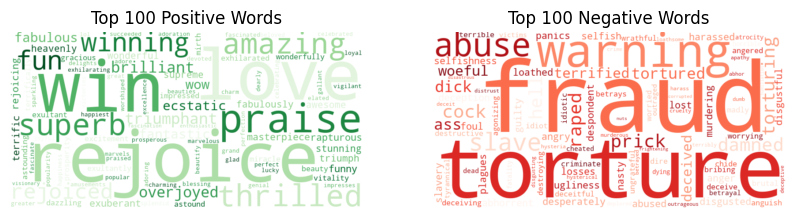

In [64]:
text = ' '.join(data['text'])
text = remove_repeating_chars(text)
text = remove_accented_chars_func(text)
text = remove_url_func(text)
text = remove_html_tags_func(text)
text = remove_email_func(text)
text = to_lower(text)
text = remove_punctuation(text)
text = remove_stopwords(text)

tokens = tokenize_sentence(text)

words = pd.DataFrame(tokens, columns=['words']).drop_duplicates()

words['score'] = words['words'].apply(afinn.score)
pos_words = words.sort_values(by='score', ascending=False).head(100)['words'].tolist()
neg_words = words.sort_values(by='score', ascending=True).head(100)['words'].tolist()

# Create word clouds for the top 100 positive and negative words
positive_wordcloud = WordCloud(width=800, height=400, background_color='white',
                               colormap='Greens').generate(" ".join(pos_words))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white',
                               colormap='Reds').generate(" ".join(neg_words))
# Display the word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.set_title('Top 100 Positive Words')
ax1.axis('off')
ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.set_title('Top 100 Negative Words')
ax2.axis('off')
plt.show()